In [3]:
import os
import time
import pickle
import pandas as pd
import numpy as np
import fathon
from fathon import fathonUtils as utils
from multiprocessing import Pool
import freqopttest.util as util
import freqopttest.data as data
import freqopttest.kernel as kernel
import freqopttest.tst as tst
import collections
from collections import defaultdict
import freqopttest.glo as glo
from scipy.stats import linregress
data_folder = 'path/to/data/folder'
symbol_list = sorted(['FB1', 'JB1', 'XM1', 'TY1', 'TU1', 'RX1', 'YM1', 'G_1', 'KE1', 'FV1', 'US1', 'DU1'])  # symbols for T71 USB Drive
window_sizes = utils.linRangeByStep(10, 1000, step=20)
polynomial_order = 2
import matplotlib.pyplot as plt
num_processes = 4  # Set the number of processes for parallelization

In [13]:
base_path ='/media/ak/T71/August11th2022Experiments'
experimentOne = os.path.join(base_path,  'ExperimentOne')
mfdfaDataframes = os.path.join(base_path, 'mfdfaDataFrames')
symbols = [f for f in os.listdir(experimentOne) if str('.pkl') not in f]
bar ='dollar'
symbolIdx = 10
symbol_path = os.path.join(experimentOne, symbols[symbolIdx])
symbol_bar_files =[f for f in os.listdir(symbol_path) if str(bar) in f]

In [11]:
print(symbols)

['FB1', 'JB1', 'XM1', 'TY1', 'TU1', 'RX1', 'YM1', 'G_1', 'KE1', 'FV1', 'US1', 'DU1']


In [14]:
# n_F = dict()
# mfSpect = dict()
# alpha = dict()
# tau = dict()
# for symbol_bar_file in symbol_bar_files:
#     file = pd.read_pickle(os.path.join(symbol_path, symbol_bar_file))[str(bar)]
#     index = symbol_bar_file.split("_")[1].split(str(bar))[0]
#     n_F[index] = file['n_F']
#     mfSpect[index] = file['mfSpect']
#     alpha[index] = file['alpha']
#     tau[index] =file['tau']
    
symbol_bar_file = symbol_bar_files[0]
file = pd.read_pickle(os.path.join(symbol_path, symbol_bar_file))[str(bar)]    

In [16]:
file.keys()

dict_keys(['n_F', 'list_H', 'list_H_intercept', 'tau', 'alpha', 'mfSpect'])

In [6]:
unpickled_Df =pd.DataFrame(tau)

In [7]:
shift = 1
window = 5  # slide
for start_point in range(0, (len - window - shift)):
    end_point = start_point + shift

#     X = np.array(unpickled_Df.iloc[:, start_point:end_point])
#     Y = np.array(unpickled_Df.iloc[:, end_point + shift:end_point + 2 * shift])
#     Z = np.array(unpickled_Df.iloc[:, start_point + window:end_point + window])   


TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'int'

In [17]:
class SymbolData:
    def __init__(self, base_path, folderName, list_of_symbols, bar):
        self.base_path = base_path
        self.folderName = folderName
        self.list_of_symbols = list_of_symbols
        self.bar = bar
        
    def return_symbol_path(self, symbolIdx):
        symbol_path = os.path.join(self.base_path, self.folderName, self.list_of_symbols[symbolIdx])
        return symbol_path
    
    def symbol_bar_files(self, symbolIdx):
        symbolPath = self.return_symbol_path(symbolIdx)
        symbol_bar_files = [f for f in os.listdir(symbolPath) if str(self.bar) in f]
        return symbol_bar_files
    def get_data(self, symbolIdx):
        symbol_bar_files = self.symbol_bar_files(symbolIdx)
        symbolPath = self.return_symbol_path(symbolIdx)
        n_F, mfSpect, alpha, tau, list_H, list_H_intercept = {}, {}, {}, {}, {}, {}
        for symbol_bar_file in symbol_bar_files:
            file = pd.read_pickle(os.path.join(symbolPath, symbol_bar_file))[str(self.bar)]
            index = symbol_bar_file.split("_")[1].split(str(self.bar))[0]
            n_F[index] = file['n_F']
            mfSpect[index] = file['mfSpect']
            alpha[index] = file['alpha']
            tau[index] =file['tau']
            list_H[index] =file['list_H']
            list_H_intercept[index] =file['list_H_intercept']

            return n_F, mfSpect, alpha, tau, list_H, list_H_intercept
    
    def loop_symbols(self):
        all_data = dict()
        symbol_paths = [self.return_symbol_path(symbolIdx) for symbolIdx in range(len(self.list_of_symbols))]
        symbol_bar_files = [self.symbol_bar_files(symbolPath) for symbolPath in symbol_paths]
        symbol_data = [self.get_data(symbol_bar_files[i], symbol_paths[i]) for i in range(len(self.list_of_symbols))]
        for i in range(len(self.list_of_symbols)):
            all_data[self.list_of_symbols[i]] = {'n_F': symbol_data[i][0], 'mfSpect': symbol_data[i][1], 'alpha': symbol_data[i][2], 'tau': symbol_data[i][3]}
        return all_data

In [18]:
symbolData = SymbolData(base_path= base_path, folderName='ExperimentOne', 
           list_of_symbols=['FB1', 'JB1', 'XM1', 'TY1', 'TU1', 'RX1', 'YM1', 'G_1', 'KE1', 'FV1', 'US1', 'DU1'], bar ='volume' )

In [19]:
path = symbolData.return_symbol_path(3)
symbolData.symbol_bar_files(3)[0].split("_")[1].split(str(bar))

['70volume']

In [20]:
files = symbolData.symbol_bar_files(3)
data_from_files = symbolData.get_data(3)

In [22]:
n_F, mfSpect, alpha, tau, list_H, list_H_intercept = data_from_files

In [23]:
mfSpectDF = pd.DataFrame(mfSpect)
alphaDF = pd.DataFrame(alpha)
no_cols = alphaDF.shape[1]
shift = 1
window = 3

In [24]:

unpickled_Df = alphaDF
test_results_one_dict = defaultdict(dict)
test_results_two_dict = defaultdict(dict)

for start_point in range(0, (no_cols - window - shift)):
    end_point = start_point + shift
    X = np.array(unpickled_Df.iloc[:, start_point:end_point])
    Y = np.array(unpickled_Df.iloc[:, end_point + shift:end_point + 2 * shift])
    Z = np.array(unpickled_Df.iloc[:, start_point + window:end_point + window])
    data_sample = data.TSTData(X, Y)  # data to train the model
    test_data_one =  data.TSTData(X, Z)
    test_data_two =  data.TSTData(Y, Z)
    tr, te = data_sample.split_tr_te(tr_proportion=0.9, seed=100)
    try:

        # choose the best kernel that maximizes the test power
        med = util.meddistance(tr.stack_xy())

        widths = [(med * f) for f in 2.0 ** np.linspace(-1, 4, 25)]
        list_kernels = [kernel.KGauss(w ** 2) for w in widths]

        besti, powers = tst.LinearMMDTest.grid_search_kernel(tr, list_kernels, alpha=0.01)
        # print(list_kernels)
        plt.plot(widths, powers, 'o-')
        plt.xlabel('Gaussian width')
        plt.ylabel('test power')
        plt.title('median distance = %.3g. Best width: %.3g' % (med, widths[besti]))
        plt.show()
        test_data_one = data_sample = data.TSTData(X, Z)
        test_data_two = data_sample = data.TSTData(Y, Z)

        # The actual test
        best_ker = list_kernels[besti]
        lin_mmd_test = tst.LinearMMDTest(best_ker, alpha=0.01)
        # test_result_one = lin_mmd_test.perform_test(test_data_one)
        # test_result_two = lin_mmd_test.perform_test(test_data_two)

        # Test 1 Results Dict
        test_results_one_dict[start_point]['widths'] = widths
        test_results_one_dict[start_point]['med'] = med
        test_results_one_dict[start_point]['widths'] = widths
        test_results_one_dict[start_point]['besti'] = besti
        test_results_one_dict[start_point]['powers'] = powers

        test_results_one_dict[start_point]['med_on_test_data'] = util.meddistance(test_data_one.stack_xy())
        test_results_one_dict[start_point]['test_result'] = lin_mmd_test.perform_test(test_data_one)
        test_results_one_dict[start_point]['test_variance'] = lin_mmd_test.variance(X, Z, best_ker)  # test variance
        test_results_one_dict[start_point]['two_moments'] = lin_mmd_test.two_moments(X, Z,
                                                                                     best_ker)  # test variance
        test_results_one_dict[start_point]['compute_unbiased_linear_estimator'] = lin_mmd_test.compute_stat(
            test_data_one)

        # Test 2 Results Dict
        test_results_two_dict[start_point]['test_result'] = lin_mmd_test.perform_test(test_data_two)
        test_results_two_dict[start_point]['test_variance'] = lin_mmd_test.variance(Y, Z, best_ker)
        test_results_two_dict[start_point]['med_on_test_data'] = util.meddistance(
            test_data_two.stack_xy())  # test variance
        test_results_two_dict[start_point]['two_moments'] = lin_mmd_test.two_moments(Y, Z,
                                                                                     best_ker)  # test variance
        test_results_two_dict[start_point]['compute_unbiased_linear_estimator'] = lin_mmd_test.compute_stat(
            test_data_two)
    except AssertionError:
        pass



In [25]:
class TestResults:
    """
    A class for plotting test results for two different test data sets
    """

    def __init__(self, unpickled_Df, window, shift):
        """
        Initialize the class

        Parameters
        ----------
        unpickled_Df : dataframe
            Unpickled dataframe.

        window : int
            Window size.

        shift : int
            Shift size.
        """
        self.unpickled_Df = unpickled_Df
        self.window = window
        self.shift = shift
        self.no_cols = unpickled_Df.shape[1]

    def get_data(self, start_point=0):
        """
        Get data from the unpickled dataframe.

        Parameters
        ----------
        start_point : int
            Start point from which the data is to be extracted

        Returns
        -------
        X : array
            Input data.

        Y : array
            Output data.

        Z : array
            Test data.
        """
        end_point = start_point + self.shift
        X = np.array(self.unpickled_Df.iloc[:, start_point:end_point])
        Y = np.array(self.unpickled_Df.iloc[:, end_point + self.shift:end_point + 2 * self.shift])
        Z = np.array(self.unpickled_Df.iloc[:, start_point + self.window:end_point + self.window])

        return X, Y, Z

    def get_test_data(self, X, Y, Z):
        """
        Get test data from the input, output and test data.

        Parameters
        ----------
        X : array
            Input data.

        Y : array
            Output data.

        Z : array
            Test data.

        Returns
        -------
        test_data_one : TSTData object
            Test data one object.

        test_data_two : TSTData object
            Test data two object.
        """
        data_sample = data.TSTData(X, Y)
        test_data_one = data.TSTData(X, Z)
        test_data_two = data.TSTData(Y, Z)

        return test_data_one, test_data_two

    def get_train_data(self, X, Y):
        """
        Get train data from the input and output data.

        Parameters
        ----------
        X : array
            Input data.

        Y : array
            Output data.

        Returns
        -------
        tr : TSTData object
            Train data object.

        te : TSTData object
            Test data object.
        """
        data_sample = data.TSTData(X, Y)
        tr, te = data_sample.split_tr_te(tr_proportion=0.9, seed=100)

        return tr, te

    def get_best_kernel(self, tr):
        """
        Get the best kernel that maximizes the test power.

        Parameters
        ----------
        tr : TSTData object
            Train data object.

        Returns
        -------
        best_ker : KGauss object
            Gaussian kernel object.

        widths : list
            List of Gaussian widths.

        besti : int
            Best Gaussian width index.

        powers : list
            List of test powers.
        """
        med = util.meddistance(tr.stack_xy())
        widths = [(med * f) for f in 2.0 ** np.linspace(-1, 4, 25)]
        try:
            list_kernels = [kernel.KGauss(w ** 2) for w in widths]
            besti, powers = tst.LinearMMDTest.grid_search_kernel(tr, list_kernels, alpha=0.01)
        except AssertionError:
            list_kernels = [kernel.KGauss(sigma2 =0.01+abs(w**2)) for w in widths]
            besti, powers = tst.LinearMMDTest.grid_search_kernel(tr, list_kernels, alpha=0.01)
        best_ker = list_kernels[besti]

        return best_ker, widths, besti, powers

    def plot_test_power(self, widths, powers, med, besti):
        """
        Plot the test power by varying the Gaussian width.

        Parameters
        ----------
        widths : list
            List of Gaussian widths.

        powers : list
            List of test powers.

        med : float
            Median distance.

        besti : int
            Best Gaussian width index.
        """
        plt.plot(widths, powers, 'o-')
        plt.xlabel('Gaussian width')
        plt.ylabel('test power')
        plt.title('median distance = %.3g. Best width: %.3g' % (med, widths[besti]))
        plt.show()

    def get_test_results_dict(self, start_point, test_data_one, test_data_two, best_ker):
        """
        Get test results in a dictionary.

        Parameters
        ----------
        start_point : int
            Start point from which the data is to be extracted.

        test_data_one : TSTData object
            Test data one object.

        test_data_two : TSTData object
            Test data two object.

        best_ker : KGauss object
            Gaussian kernel object.

        Returns
        -------
        test_results_one_dict : dict
            Dictionary of test results for test data one.

        test_results_two_dict : dict
            Dictionary of test results for test data two.
        """
        test_results_one_dict = defaultdict(dict)
        test_results_two_dict = defaultdict(dict)

        X, Y, Z = self.get_data(start_point)

        # Test 1 Results Dict
        test_results_one_dict[start_point]['med_on_test_data'] = util.meddistance(test_data_one.stack_xy())
        test_results_one_dict[start_point]['test_result'] = lin_mmd_test.perform_test(test_data_one)
        test_results_one_dict[start_point]['test_variance'] = lin_mmd_test.variance(X, Z, best_ker)  # test variance
        test_results_one_dict[start_point]['two_moments'] = lin_mmd_test.two_moments(X, Z,
                                                                                     best_ker)  # test variance
        test_results_one_dict[start_point]['compute_unbiased_linear_estimator'] = lin_mmd_test.compute_stat(
            test_data_one)

        # Test 2 Results Dict
        test_results_two_dict[start_point]['test_result'] = lin_mmd_test.perform_test(test_data_two)
        test_results_two_dict[start_point]['test_variance'] = lin_mmd_test.variance(Y, Z, best_ker)
        test_results_two_dict[start_point]['med_on_test_data'] = util.meddistance(
            test_data_two.stack_xy())  # test variance
        test_results_two_dict[start_point]['two_moments'] = lin_mmd_test.two_moments(Y, Z,
                                                                                     best_ker)  # test variance
        test_results_two_dict[start_point]['compute_unbiased_linear_estimator'] = lin_mmd_test.compute_stat(
            test_data_two)

        return test_results_one_dict, test_results_two_dict

    def plot_results(self):
        """
        Plot the test power and test results for both the test data sets.
        """
        test_results_one_dict = defaultdict(dict)
        test_results_two_dict = defaultdict(dict)

        for start_point in range(0, (self.no_cols - self.window - self.shift)):
            X, Y, Z = self.get_data(start_point)
            try:
                test_data_one, test_data_two = self.get_test_data(X, Y, Z)
                tr, te = self.get_train_data(X, Y)
                best_ker, widths, besti, powers = self.get_best_kernel(tr)
                test_results_one_dict, test_results_two_dict = self.get_test_results_dict(start_point, test_data_one,
                                                                                         test_data_two, best_ker)

                # Plot the test power
                self.plot_test_power(widths, powers, med, besti)
            except (AssertionError, ValueError):
                pass

        # Plot the test results
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.plot(list(test_results_one_dict.keys()),
                 [val['test_result'][0] for val in test_results_one_dict.values()])
        plt.title('Test Result for Test Data One')
        plt.xlabel('Start Point')
        plt.ylabel('Test Result')

        plt.subplot(1, 2, 2)
        plt.plot(list(test_results_two_dict.keys()),
                 [val['test_result'][0] for val in test_results_two_dict.values()])
        plt.title('Test Result for Test Data Two')
        plt.xlabel('Start Point')
        plt.ylabel('Test Result')
        plt.show()
        return test_results_one_dict, test_results_two_dict

In [26]:
testRez = TestResults(unpickled_Df=mfSpectDF, window = 1, shift = 3)

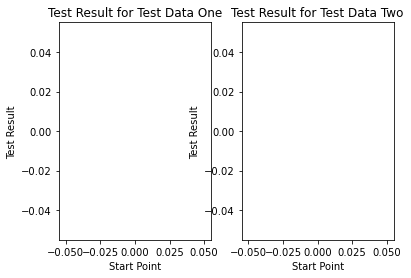

In [27]:
test_results_one_dict, test_results_two_dict =testRez.plot_results()

In [28]:
test_results_one_dict

defaultdict(dict,
            {0: {'widths': [0.1117643166224907,
               0.12912720462388122,
               0.14918746410177902,
               0.17236413898952582,
               0.19914137282561595,
               0.23007852215292218,
               0.26582184106176565,
               0.3071179809582637,
               0.35482958755809735,
               0.40995332091532405,
               0.4736406749112641,
               0.5472220311071326,
               0.6322344494275485,
               0.7304537762016748,
               0.8439317402751407,
               0.9750388121029945,
               1.126513721118332,
               1.301520665757685,
               1.503715411218137,
               1.7373216556792739,
               2.007219260223652,
               2.3190461855133644,
               2.6793162646042243,
               3.0955552720842343,
               3.5764581319197024],
              'med': 0.2235286332449814,
              'besti': 0,
              'powers'

In [29]:
test_results_two_dict

defaultdict(dict,
            {0: {'test_result': {'alpha': 0.01,
               'pvalue': 5.761657783842484e-06,
               'test_stat': 0.6807374305499737,
               'h0_rejected': True},
              'test_variance': -0.5385160762529928,
              'med_on_test_data': 0.19718602889547945,
              'two_moments': (0.6807374305499737, 0.830918719584601),
              'compute_unbiased_linear_estimator': 0.6807374305499737},
             1: {'test_result': {'alpha': 0.01,
               'pvalue': 0.0002205625362406361,
               'test_stat': 0.5598115119928947,
               'h0_rejected': True},
              'test_variance': -0.30686366784098235,
              'med_on_test_data': 0.2651614558713719,
              'two_moments': (0.5598115119928947, 0.8755005400680064),
              'compute_unbiased_linear_estimator': 0.5598115119928947},
             2: {'test_result': {'alpha': 0.01,
               'pvalue': 2.612267844396512e-06,
               'test_stat